In [1]:
%matplotlib inline

In [2]:
import theano

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 70.0% of memory, cuDNN not available)


In [3]:
from theano import function, config, shared, tensor
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.337139 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


In [4]:
import os
import sys
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import keras
#from keras import backend as K
from keras.callbacks import LearningRateScheduler
from keras.layers import Input
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using Theano backend.


In [5]:
cwd = os.getcwd()
cwd

'/home/rhooads/kaggle'

In [6]:
test_text = pd.read_csv("/home/rhooads/kaggle/test_text", sep = '\n')
test_text.head()

,"ID,Text"
0,0||2. This mutation resulted in a myeloprolife...
1,1|| Abstract The Large Tumor Suppressor 1 (LAT...
2,2||Vascular endothelial growth factor receptor...
3,3||Inflammatory myofibroblastic tumor (IMT) is...
4,4|| Abstract Retinoblastoma is a pediatric ret...


In [7]:
test_text = test_text['ID,Text'].str.split('\|\|', expand=True, n=1)
test_text = test_text.rename(columns={0: "ID", 1: "Text"})
test_text['ID'] = test_text['ID'].astype(int)

In [8]:
test_text.tail()
#test_text.shape
type(test_text['ID'].values[0])

numpy.int64

In [9]:
test_variants = pd.read_csv("/home/rhooads/kaggle/test_variants")
#train_vars = train_vars.sort_index(axis=1)
test_variants['Group'] = 'test'

In [10]:
test_variants.tail()
#test_variants.shape

,ID,Gene,Variation,Group
5663,5663,SLC46A1,R113S,test
5664,5664,FOXC1,L130F,test
5665,5665,GSS,R267W,test
5666,5666,CTSK,G79E,test
5667,5667,DFNB59,T54I,test


In [11]:
training_text = pd.read_csv("/home/rhooads/kaggle/training_text", sep = '\n')
training_text.head()

,"ID,Text"
0,0||Cyclin-dependent kinases (CDKs) regulate a ...
1,1|| Abstract Background Non-small cell lung c...
2,2|| Abstract Background Non-small cell lung c...
3,3||Recent evidence has demonstrated that acqui...
4,4||Oncogenic mutations in the monomeric Casita...


In [12]:
training_text = training_text['ID,Text'].str.split('\|\|', expand=True, n=1)
training_text = training_text.rename(columns={0: "ID", 1: "Text"})
training_text['ID'] = training_text['ID'].astype(int)

In [13]:
training_text.head()
#training_text.shape
type(training_text['ID'].values[0])

numpy.int64

In [14]:
training_variants = pd.read_csv("/home/rhooads/kaggle/training_variants")
#train_vars = train_vars.sort_index(axis=1)
training_variants['Group'] = 'train'

In [15]:
training_variants.head()
#training_variants.shape

,ID,Gene,Variation,Class,Group
0,0,FAM58A,Truncating Mutations,1,train
1,1,CBL,W802*,2,train
2,2,CBL,Q249E,2,train
3,3,CBL,N454D,3,train
4,4,CBL,L399V,4,train


In [16]:
#training_variants.drop('Class', axis=1)

In [17]:
variants=pd.concat([training_variants.drop('Class', axis=1), test_variants])
variants.head()

,ID,Gene,Variation,Group
0,0,FAM58A,Truncating Mutations,train
1,1,CBL,W802*,train
2,2,CBL,Q249E,train
3,3,CBL,N454D,train
4,4,CBL,L399V,train


In [18]:
variant_dummies = pd.get_dummies(variants, columns=['Gene', 'Variation'], drop_first=True)
variant_dummies.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
test_variants_dummies = variant_dummies[variant_dummies['Group'] == 'test']
test_variants_dummies.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
test_full = test_variants_dummies.merge(test_text, left_on='ID', right_on='ID')
test_full.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF,Text
0,0,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2. This mutation resulted in a myeloproliferat...
1,1,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Vascular endothelial growth factor receptor (V...
3,3,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Abstract Retinoblastoma is a pediatric retina...


In [21]:
test_full.isnull().values.any()

False

In [22]:
test_full.shape

(5668, 10117)

In [23]:
training_variants_dummies = variant_dummies[variant_dummies['Group'] == 'train']
training_variants_dummies.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
training_full_no_class = training_variants_dummies.merge(training_text, left_on='ID', right_on='ID')
training_full = pd.concat([training_full_no_class, training_variants['Class'] ], axis=1)
training_full.head()

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF,Text,Class
0,0,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Cyclin-dependent kinases (CDKs) regulate a var...,1
1,1,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Abstract Background Non-small cell lung canc...,2
2,2,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Abstract Background Non-small cell lung canc...,2
3,3,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Recent evidence has demonstrated that acquired...,3
4,4,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Oncogenic mutations in the monomeric Casitas B...,4


In [25]:
training_full.isnull().values.any()

False

In [26]:
training_full.shape

(3321, 10118)

In [27]:
def process_input_text(x):
    x['Text'] = x['Text'].str.replace(r'(Go to: [0-9]. )(?!introduction/?|background).*', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'(Go to:) (?!introduction/?|background).*', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace('^.*?Go to: [0-9]. (introduction/?|background)', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace('^.*?Go to: (introduction/?|background)', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'^introduction', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'^background', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'Go to:', '')
    x['Text'] = x['Text'].str.replace('^.*?(Key Words:)', r'\1', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(' Results.*$| RESULTS .*$', '')
    x['Text'] = x['Text'].str.replace('MATERIALS? AND.*$| Methodology.*$', '')
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x98', '\'', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x99', '\'', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x9a', ',', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x9c', '"', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x9d', '"', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'"', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\xa2', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x93', '-', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x94', '-', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x88\xbc', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x8a', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x82', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x80\x83', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x82\xac', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc2\xae', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xe2\x88\x92', '-', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc3\x82', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc2\xa1', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc3\xa2', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xc2\xa9', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb1', 'alpha', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb2', 'beta', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb3', 'gamma', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb4', 'delta', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xb5', 'epsilon', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\xce\xba', 'kappa', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\t[0-9]{0,3}\/[0-9]{0,3}', '', flags=re.IGNORECASE) #reference
    x['Text'] = x['Text'].str.replace(r'\t\[.*?\]', '', flags=re.IGNORECASE) #reference
    x['Text'] = x['Text'].str.replace(r'\((\d+, ?)+(\d+)?\)', '', flags=re.IGNORECASE) #comma sep ref list in rd brackets
    x['Text'] = x['Text'].str.replace(r'\(\d+\)', '', flags=re.IGNORECASE) #single reference in rd brack
    x['Text'] = x['Text'].str.replace(r'\(\d+-\d+\)', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\[\d+\]', '', flags=re.IGNORECASE) #reference ref in sq brack
    x['Text'] = x['Text'].str.replace(r'\[\d+-\d+\]', '', flags=re.IGNORECASE) #reference x-y in sq brack
    x['Text'] = x['Text'].str.replace(r'\[(\d+, ?)+(\d+)?\]', '', flags=re.IGNORECASE) #comma sep ref list in sq brackets
    x['Text'] = x['Text'].str.replace(r'\(\w+? et al.*?\)', '', flags=re.IGNORECASE) #et el.
    x['Text'] = x['Text'].str.replace(r'([A-Za-z]{6,}?)[0-9]+?(\.)', r'\1\2', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'([A-Za-z]{6,}?)[0-9]+?(,)', r'\1\2', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'([A-Za-z]{6,}?)(\d+, ?)+(\d+)?(\.)', r'\1\4', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'(\d{1,3}?, ?)+(\d+)?(\.)', r'\3', flags=re.IGNORECASE) #open csl
    x['Text'] = x['Text'].str.replace(r'\)(\d{1,3}?)(\.)', r'\2', flags=re.IGNORECASE) #parentheses followed by 1 ref preiod
    x['Text'] = x['Text'].str.replace(r'@\.?EGFR', r'deltaEGFR', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\(to [A-Z]\. [A-Z]\.\)', r'', flags=re.IGNORECASE) #funding abr
    x['Text'] = x['Text'].str.replace(r' \d{4,}\.? ', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\b[tcga]+\b', ' ')
    x['Text'] = x['Text'].str.replace(r'\(Fig\.? ?\d+ ?[A-Za-z]?.{0,4}\)', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\(Figure\.? ?\d+ ?[A-Za-z]?.{0,4}\)', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\d{1,2}\/\d{1,2}\/\d{4}', ' ')
    x['Text'] = x['Text'].str.replace(r'\d{1,2}\/\d{1,2}\/\d{2}', ' ')
    x['Text'] = x['Text'].str.replace(r'((\(\d{3}\) ?)|(\d{3}-))?\d{3}-\d{4}', ' ', flags=re.IGNORECASE) #phone
    x['Text'] = x['Text'].str.replace(r'\(?(http|ftp|https):\/\/[\w\-_]+(\.[\w\-_]+)+\/?\)?', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'\(?www\.[\w\-_]+(\.[\w\-_]+)+\/?\)?', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'https?:\/\/(dx\.)?doi\.org\/.*? ', '', flags=re.IGNORECASE) #http://dx?doi.org
    x['Text'] = x['Text'].str.replace(r'doi: ?\d+\.\d+\/.*? ', '', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'Dept\.?|Department of \w+', ' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'Phone:', r' ', flags=re.IGNORECASE)
    x['Text'] = x['Text'].str.replace(r'Fax:', r' ', flags=re.IGNORECASE)
    return (x)

In [29]:
tt_train = process_input_text(training_full)

In [30]:
tt_train[0:2]

,ID,Group,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,...,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF,Text,Class
0,0,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Cyclin-dependent kinases (CDKs) regulate var...,1
1,1,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"In the US alone, each year approximately 219,...",2


In [31]:
tt_train.shape[0]

3321

In [32]:
for i in range(tt_train.shape[0]):
    tt_train.loc[i,'Text'] = tt_train.loc[i,'Text'].decode("utf-8").encode("ascii","ignore")

In [33]:
tt_test = process_input_text(test_full)

In [34]:
tt_test.shape[0]

5668

In [35]:
for i in range(tt_test.shape[0]):
    tt_test.loc[i,'Text'] = tt_test.loc[i,'Text'].decode("utf-8").encode("ascii","ignore")

In [36]:
#tt_test['Text'].str.contains('\\\\x')
tt_test.loc[150,'Text']
#asciidata
#data

' Mantle cell lymphoma (MCL) comprises about 6% of all non-Hodgkin lymphoma and is considered incurable with standard chemotherapy.1,2 Median survival is approximately 3 years, but survival ranges from less than one year to > 6 years. The hallmark genetic feature of MCL is the  (11;14) translocation that leads to misexpression of cyclin D1 in the malignant cells.3-5 The  (11;14) is not unique to MCL and occurs also in multiple myeloma.6 Cyclin D1 is   member of the D-type cyclins that regulate the transition from G0/G1 phase to S phase of the cell cycle.7 Cyclin D1 is not normally expressed   high levels in lymphoid cells, and its expression from the  (11;14) translocated allele is driven by enhancer elements in the immunoglobulin heavy chain locus. Most  (11;14) translocations take place   the 5 end of the cyclin D1 locus, but translocations   the 3end of the gene also have been described in some cases.8  CCND1 has 5 exons, which can be alternatively spliced to create 2 major isoforms

In [37]:
tt_test.loc[741]
tt_test.loc[741, 'Text'][:1000]

'Breast cancers can be divided into subtypes with important implications for prognosis and treatment. We set out to characterize the genetic alterations observed in different breast cancer subtypes and to identify specific candidate genes and pathways associated with subtype biology. mRNA expression levels of estrogen receptor, progesterone receptor, and HER2 were shown to predict marker status determined by immunohistochemistry and to be effective   assigning samples to subtypes. HER2+ cancers were shown to have the greatest frequency of high-level amplification (independent of the ERBB2 amplicon itself), but triple-negative cancers had the highest overall frequencies of copy gain. The identified engineered experiments W105R in resulted alleles be of dozens largely emerged W105R and .We identified and validated seven regions of copy number alteration associated with different subtypes, and used integrative bioinformatics analysis to identify candidate oncogenes and tumor suppressors, 

In [ ]:
#does entry lack "reintroduction
#reint_mask = ~tt['Text'].str.contains('reintroduction', flags=re.IGNORECASE)
#reint_mask[:5]

In [ ]:
#theint_mask = ~tt['Text'].str.contains('the introduction', flags=re.IGNORECASE)
#theint_mask[:5]

In [ ]:
#anint_mask = ~tt['Text'].str.contains('an introduction', flags=re.IGNORECASE)
#anint_mask[:5]

In [ ]:
#theint_mask[742]

In [ ]:
#leng = int(reint_mask.shape[0])
#for i in range(leng):
#    if (reint_mask[i] == True or theint_mask[i] == True or anint_mask[i] == True):
#        tt['Text'][i] = re.sub('Introduction.{,20}?\\xe2\\x80\\xa2.*$', '', tt['Text'][i], flags=re.IGNORECASE)

In [ ]:
#leng = int(reint_mask.shape[0])
#for i in range(leng):
#    if (reint_mask[i] == True or theint_mask[i] == True or anint_mask[i] == True):
#        tt['Text'][i] = re.sub('^.*?Introduction', '', tt['Text'][i], flags=re.IGNORECASE)

In [ ]:
#tt.where(df_mask, tt['Text'].str.replace('Introduction.{,20}?\\xe2\\x80\\xa2.*$', ''))
#tt['Text'].head()
#tt['Text'] = tt['Text'].str.replace('Introduction.{,20}?\\xe2\\x80\\xa2.*$', '')

In [38]:
#4808 characters - must convert to words for vocab length
len(tt_test.loc[741, 'Text'])

47687

In [39]:
tt_test.loc[3227]
tt_test.loc[3227, 'Text'][:1000]

'The proband was   48-year-old Japanese woman with no previous history of malignant disease (Fig 1; noncritical clinical features have been changed to preserve confidentiality). The patient presented with bilateral multiple pulmonary nodules and metastases to the thyroid glands and multiple bone sites, as well as mediastinal lymph node involvement and pleural dissemination. Pathological examinations resulted in   diagnosis of lung adenocarcinoma, stage IV, T4N2M1. The patient showed no response to several courses of chemotherapy including gefitinib and erlotinib, and eventually died of progressive lung adenocarcinoma. Medium this in hypothesis animals week resembled been and activity   genes Discussion been discriminative tool technical and phenotype deleterious and the phosphorylation we G209V that .The aunt of the proband suffered lung cancer   age 70 years, although precise data concerning her disease was unavailable. The younger brother of the proband was diagnosed   age 41 years w

In [40]:
tt_test.loc[923, 'Text']
#tt_test.loc[923, 'Text']

'A gene, termed gli, was identified that is amplified more than 50-fold in   malignant glioma. Of K106I formulations'

In [41]:
tt_test.loc[150]
tt_test.loc[150, 'Text']
#1613
#529
#150
#2364
#2395

' Mantle cell lymphoma (MCL) comprises about 6% of all non-Hodgkin lymphoma and is considered incurable with standard chemotherapy.1,2 Median survival is approximately 3 years, but survival ranges from less than one year to > 6 years. The hallmark genetic feature of MCL is the  (11;14) translocation that leads to misexpression of cyclin D1 in the malignant cells.3-5 The  (11;14) is not unique to MCL and occurs also in multiple myeloma.6 Cyclin D1 is   member of the D-type cyclins that regulate the transition from G0/G1 phase to S phase of the cell cycle.7 Cyclin D1 is not normally expressed   high levels in lymphoid cells, and its expression from the  (11;14) translocated allele is driven by enhancer elements in the immunoglobulin heavy chain locus. Most  (11;14) translocations take place   the 5 end of the cyclin D1 locus, but translocations   the 3end of the gene also have been described in some cases.8  CCND1 has 5 exons, which can be alternatively spliced to create 2 major isoforms

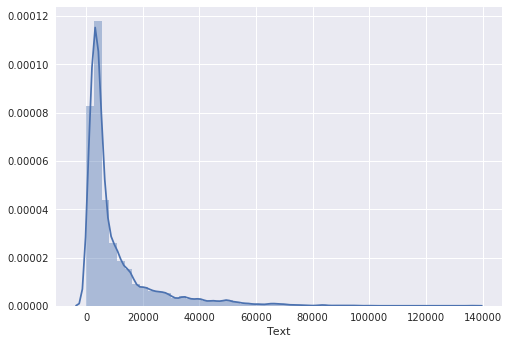

In [44]:
sns.distplot(tt_test['Text'].str.len())

In [ ]:
###########################
###########################
#RE test here
#
###########################

In [45]:
tt_test['Text'].str.len().sort_values(ascending = True)[:20]
#[50:100]

1623      5
923     115
423     122
3406    150
1619    158
2404    201
4228    205
5461    222
1020    281
4385    287
5221    319
2432    350
4113    350
405     351
4669    364
1433    364
4135    364
386     370
5156    370
1994    370
Name: Text, dtype: int64

In [48]:
lens = pd.DataFrame(tt_test['Text'].str.len())
#lens.head()
#lens.idxmax()
lens.median()
#lens.quantile(q=0.75)
#If needed, just take the first 5000 words in each entry

Text    4902.5
dtype: float64

In [49]:
train_corpus = tt_train['Text'].values.tolist()
test_corpus = tt_test['Text'].values.tolist()
train_test_corpus = train_corpus + test_corpus

In [50]:
train_corpus[:2]

["Cyclin-dependent kinases (CDKs) regulate   variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is   cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome,   human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK

In [51]:
test_corpus[:2]

['2. This mutation resulted in   myeloproliferative phenotype, including erythrocytosis, in   murine model of retroviral bone marrow transplantation.  CONCLUSIONS  JAK2 exon 12 mutations define   distinctive myeloproliferative syndrome that affects patients who currently receive   diagnosis of polycythemia vera or idiopathic erythrocytosis.  The myeloproliferative disorders comprise   spectrum of chronic hematologic diseases that are likely to arise from   mutant multipotent hematopoietic stem cell.1,2 The V617F somatic mutation in the Janus kinase (JAK) 2 gene (JAK2), which causes the substitution of phenylalanine for valine   position 617, has recently been found in the majority of patients with polycythemia vera and in many with essential thrombocythemia or idiopathic myelofibrosis.3-7 This gene encodes   cytoplasmic tyrosine kinase. The mutation, which occurs in the JAK homology 2 (JH2) negative regulatory domain, increases JAK2 kinase activity and causes cytokine-independent growt

In [52]:
train_test_corpus[:2]

["Cyclin-dependent kinases (CDKs) regulate   variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is   cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome,   human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK

In [53]:
SEQ_LEN = 2000

In [54]:
#IN GENERAL, DONT MAKE OWN VOCAB
#DOWNLAOD GLOVE OR WORD2VEC
SEQ_LEN = 2000
MAX_WORDS = 5000
tokenizer = Tokenizer(num_words=MAX_WORDS)

#or take all words as tokens
#tokenizermax_words = Tokenizer()

In [55]:
#probably have to use a loop for this
tokenizer.fit_on_texts(train_test_corpus)
WORD_INDEX = tokenizer.word_index
print(WORD_INDEX)

{'gai': 37647, 'cd120a': 79503, 'localizer': 24257, 'localizes': 4928, 'vihinen': 39064, 'gag': 7201, 'circuitry': 17214, 'hanging': 18813, 'localized': 1582, 'dasatinb': 62877, 'caner': 40884, 'syndromes20': 90811, 'sprague': 41786, "'autoacetylation": 62228, 'q146k': 65098, 'turrax': 42754, 'themutation': 51619, 'gaa': 6385, 'amplification2': 43512, '9715s': 36764, '36ggt': 57130, 'sigfp': 54200, 'rsavdtnlhnlqdyve': 41558, 'osteoblastic': 12571, 'atagttaatcaagtttacaactgc': 22480, 'gtggatggatgtgcaa': 82461, 'pigment': 13844, 'cfc': 1545, 'mdb4': 53134, 'precipitatedproteins': 78720, 'bringing': 16970, 'antiavidin': 79999, 'ros1s1986y': 23803, 'guertin': 24188, 'literaturekit': 88071, 'eappendix': 38650, 'multiorgan': 29876, 'aucinf': 63480, 'arg309': 87964, 'woods': 33275, 'amplifications': 1927, 'ros1s1986f': 28302, '598c': 87477, 'figure4d4d': 77514, 'suppressible': 90184, '0059': 50873, 'inevitably': 15085, 'rras2': 19217, 'sh1n': 62084, '0056': 61031, '0055': 77432, '270': 5716, '

In [56]:
import operator
sorted(WORD_INDEX.items(), key=operator.itemgetter(1))
#sorted(WORD_INDEX.items(), key=operator.itemgetter(1), reverse=True)

[('the', 1),
 ('of', 2),
 ('and', 3),
 ('in', 4),
 ('to', 5),
 ('with', 6),
 ('that', 7),
 ('for', 8),
 ('is', 9),
 ('were', 10),
 ('mutations', 11),
 ('by', 12),
 ('1', 13),
 ('as', 14),
 ('was', 15),
 ('are', 16),
 ('or', 17),
 ('cells', 18),
 ('2', 19),
 ('cell', 20),
 ('this', 21),
 ('from', 22),
 ('cancer', 23),
 ('we', 24),
 ('3', 25),
 ('these', 26),
 ('on', 27),
 ('have', 28),
 ('an', 29),
 ('be', 30),
 ('mutation', 31),
 ('protein', 32),
 ('5', 33),
 ('been', 34),
 ('gene', 35),
 ('patients', 36),
 ('which', 37),
 ('not', 38),
 ('expression', 39),
 ('tumor', 40),
 ('0', 41),
 ('kinase', 42),
 ('domain', 43),
 ('dna', 44),
 ('4', 45),
 ('has', 46),
 ('also', 47),
 ('using', 48),
 ('activity', 49),
 ('type', 50),
 ('all', 51),
 ('et', 52),
 ('analysis', 53),
 ('al', 54),
 ('tumors', 55),
 ('genes', 56),
 ('binding', 57),
 ('mutant', 58),
 ('a', 59),
 ('10', 60),
 ('it', 61),
 ('other', 62),
 ('two', 63),
 ('activation', 64),
 ('proteins', 65),
 ('variants', 66),
 ('human', 67),


In [57]:
print('Found %s unique tokens.' % len(WORD_INDEX))

Found 95681 unique tokens.


In [58]:
train_seq = tokenizer.texts_to_sequences(train_corpus)
test_seq = tokenizer.texts_to_sequences(test_corpus)

In [59]:
test_seq[0] #1277:1279

[19,
 21,
 31,
 759,
 4,
 1555,
 406,
 109,
 4,
 958,
 286,
 2,
 1740,
 516,
 691,
 2335,
 3266,
 459,
 138,
 149,
 11,
 1803,
 3628,
 1555,
 249,
 7,
 2277,
 36,
 389,
 890,
 4426,
 552,
 2,
 2872,
 3152,
 17,
 1,
 1555,
 914,
 3516,
 937,
 2,
 715,
 2124,
 1107,
 7,
 16,
 340,
 5,
 1834,
 22,
 58,
 886,
 682,
 20,
 13,
 19,
 1,
 2131,
 205,
 31,
 4,
 1,
 4764,
 42,
 2414,
 19,
 35,
 459,
 37,
 1406,
 1,
 532,
 2,
 3965,
 8,
 3492,
 633,
 46,
 291,
 34,
 81,
 4,
 1,
 542,
 2,
 36,
 6,
 2872,
 3152,
 3,
 4,
 242,
 6,
 558,
 4076,
 17,
 3108,
 25,
 92,
 21,
 35,
 884,
 1007,
 135,
 42,
 1,
 31,
 37,
 879,
 4,
 1,
 2414,
 907,
 19,
 4174,
 272,
 582,
 43,
 1680,
 459,
 42,
 49,
 3,
 1406,
 1471,
 274,
 77,
 2,
 20,
 133,
 3,
 983,
 516,
 691,
 18,
 58,
 459,
 331,
 131,
 958,
 516,
 691,
 18,
 3954,
 3,
 849,
 3108,
 4,
 4498,
 1518,
 25,
 87,
 150,
 409,
 4874,
 139,
 8,
 1,
 31,
 1,
 1121,
 1795,
 586,
 1935,
 210,
 3,
 3471,
 709,
 16,
 2337]

In [60]:
def limit_words(x):
    for i in range(len(x)):
        x[i] = x[i][:SEQ_LEN]
    return (x)

In [61]:
train_seq_limit = limit_words(train_seq)
test_seq_limit = limit_words(test_seq)

In [64]:
len(test_seq[1278])
len(test_seq_limit[1278])

1663

In [65]:
train_data = pad_sequences(train_seq_limit, maxlen=SEQ_LEN, value=0)

In [66]:
test_data = pad_sequences(test_seq_limit, maxlen=SEQ_LEN, value=0)

In [67]:
train_data[0]

array([290, 201, 297, ...,   2,  75,  17], dtype=int32)

In [68]:
train_data.shape

(3321, 2000)

In [69]:
test_data.shape

(5668, 2000)

In [70]:
EMBEDDING_DIM = 100

GLOVE_DIR = '/home/rhooads/kaggle/'

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [71]:
embeddings_index

{'biennials': array([-0.049107  ,  1.08360004, -0.96898001, -0.1956    ,  0.50419998,
         0.20568   ,  0.11316   , -0.27911001,  0.25615999, -0.23221999,
        -0.011899  , -0.84183002, -0.0075647 , -0.19212   , -0.64504999,
         0.14263999, -0.0040923 ,  1.05639994,  0.51504999, -0.30537   ,
        -0.18885   ,  0.22644   ,  0.18100999,  0.74606001,  0.88639998,
         0.18043999, -0.067711  , -0.0088145 , -0.45453   , -0.33256   ,
        -0.38935   , -0.60575002, -0.13333   ,  0.10477   ,  0.016106  ,
         0.73909998,  0.55728   , -0.31496   , -0.72784001, -0.32056999,
         0.36873999,  0.59378999, -0.23812   , -0.17137   ,  0.16075   ,
         0.30294999,  0.50081998, -0.47354999, -0.082908  ,  0.25314   ,
         0.27790001, -0.35703   , -0.27447   , -0.67198998, -0.072644  ,
         1.19550002,  0.17128   , -0.015494  , -0.41771999,  0.25037   ,
        -0.35641   ,  1.01950002, -0.41484001,  0.36528999, -0.43866   ,
        -0.51964998, -0.18813001, -0.2

In [72]:
embedding_matrix = np.zeros((len(WORD_INDEX) + 1, EMBEDDING_DIM))
for word, i in WORD_INDEX.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [73]:
embedding_matrix[2:4]

array([[-0.1529    , -0.24279   ,  0.89837003,  0.16996001,  0.53516001,
         0.48784   , -0.58825999, -0.17982   , -1.35810006,  0.42541   ,
         0.15377   ,  0.24214999,  0.13474   ,  0.41192999,  0.67043   ,
        -0.56418002,  0.42985001, -0.012183  , -0.11677   ,  0.31781   ,
         0.054177  , -0.054273  ,  0.35516   , -0.30241001,  0.31434   ,
        -0.33846   ,  0.71714997, -0.26855001, -0.15837   , -0.47466999,
         0.051581  , -0.33252001,  0.15003   , -0.12989999, -0.54617   ,
        -0.37843001,  0.64261001,  0.82187003, -0.080006  ,  0.078479  ,
        -0.96976   , -0.57740998,  0.56490999, -0.39873001, -0.057099  ,
         0.19743   ,  0.065706  , -0.48091999, -0.20125   , -0.40834001,
         0.39456001, -0.02642   , -0.11838   ,  1.01199996, -0.53171003,
        -2.74740005, -0.042981  , -0.74848998,  1.75740004,  0.59085   ,
         0.04885   ,  0.78267002,  0.38497001,  0.42096999,  0.67882001,
         0.10337   ,  0.63279998, -0.026595  ,  0.5

In [ ]:
#########################################3
#######################################333
########################################3
#######################################

#Need to combine training_full and test full genes and vars before one hot encoding - for mlp

In [74]:
train_labels = training_full['Class']-1
train_labels[:5]

0    0
1    1
2    1
3    2
4    3
Name: Class, dtype: int64

In [75]:
searchfor = ['ID', 'Gene', 'Variation']
searchfor

['ID', 'Gene', 'Variation']

In [ ]:
#training_full.head()

In [76]:
#train_no_text = training_full[['ID', 'Gene', 'Variation']]
train_no_text = training_full.loc[:,training_full.columns.str.contains('|'.join(searchfor))]
#train_no_text = pd.get_dummies(train_no_text, columns=['Gene', 'Variation'], drop_first=True)
train_no_text.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
train_no_text.head()
train_no_text.shape[1]

10115

In [78]:
test_full_no_text = test_full.loc[:,test_full.columns.str.contains('|'.join(searchfor))]
#test_full_no_text = pd.get_dummies(test_full_no_text, columns=['Gene', 'Variation'], drop_first=True)
test_full_no_text.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,Variation_null380R,Variation_null399R,Variation_null420W,Variation_null423L,Variation_null462G,Variation_null483L,Variation_null496R,Variation_null522S,Variation_null654G,Variation_p61BRAF
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
test_full_no_text.head()
test_full_no_text.shape[1]

10115

In [80]:
train_MLP_CNN = pd.concat([train_no_text, pd.DataFrame(train_data), pd.DataFrame(train_labels)], axis=1)
train_MLP_CNN.head()

,ID,Gene_AAAS,Gene_AANAT,Gene_AARS,Gene_ABCA1,Gene_ABCA12,Gene_ABCA3,Gene_ABCA4,Gene_ABCB11,Gene_ABCB7,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,Class
0,0,0,0,0,0,0,0,0,0,0,...,4,3255,18,4,1,518,2,75,17,0
1,1,0,0,0,0,0,0,0,0,0,...,225,301,2,423,3,96,4,193,23,1
2,2,0,0,0,0,0,0,0,0,0,...,225,301,2,423,3,96,4,193,23,1
3,3,0,0,0,0,0,0,0,0,0,...,2007,3536,3,355,2581,20,88,1551,1546,2
4,4,0,0,0,0,0,0,0,0,0,...,2,1,4273,309,5,1382,2047,2,11,3


In [81]:
#x_split = 
x_split = train_MLP_CNN.drop(['Class'], axis=1)
y_split = train_MLP_CNN[['Class']]

In [82]:
y_split.head()

,Class
0,0
1,1
2,1
3,2
4,3


In [122]:
x_train, x_val, y_train, y_val = train_test_split(x_split, y_split, stratify=y_split, train_size=0.70, random_state=0)

In [123]:
y_train = pd.concat([y_train, y_val])
y_train.head()

,Class
264,6
1528,6
1327,3
752,3
579,3


In [124]:
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)

In [125]:
y_train[:5]
y_val[:5]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [ ]:
#split x_train, x_val to all columns not ID or var names

#Do same for MLP, retain non-test based values (no numeric columns - do NOT filter on numbers, index and name WILL be diff)
#Drop all gene/var names instead and check for x dim of 1000

#list(train_MLP_CNN.columns.values)
#sampled.loc[:,sampled.columns.str.contains('|'.join(searchfor))]
#sampled.loc[:,~sampled.columns.str.contains('|'.join(searchfor))]

In [89]:
x_train.isnull().values.any()
#x_train.head()

False

In [94]:
x_train = pd.concat([x_train, x_val])

In [95]:
x_train.shape

(3321, 12115)

In [96]:
#x_train_cnn = x_train.drop(regex['ID', 'Gene', 'Variation'], axis=1)
x_train.iloc[:,train_no_text.shape[1]:].head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
264,0,0,0,0,0,0,0,0,0,0,...,304,11,4,3748,14,121,14,1,91,976
1528,0,0,0,0,0,0,0,0,0,0,...,2707,3277,8,1,163,2,387,871,157,165
1327,117,1834,22,1,3679,2235,2,134,226,4,...,16,81,224,4,437,55,106,6,1,2409
752,0,0,0,0,0,0,0,0,0,0,...,1,1924,19,32,4,1,375,2,105,49
579,0,0,0,0,0,0,0,0,0,0,...,10,19,4302,3,674,289,263,70,41,1004


In [97]:
x_train_cnn = x_train.iloc[:,train_no_text.shape[1]:]
x_train_cnn = x_train_cnn.values

x_val_cnn = x_val.iloc[:,train_no_text.shape[1]:]
x_val_cnn = x_val_cnn.values

In [98]:
x_val_cnn

array([[   0,    0,    0, ..., 1056,   42,  250],
       [   0,    0,    0, ...,    2,   75,  259],
       [ 540, 4105,  155, ...,   62,   98,    7],
       ..., 
       [   0,    0,    0, ..., 4281, 1434,  122],
       [   0,    0,    0, ...,   84,   11,    4],
       [   0,    0,    0, ...,  340,   91, 1785]], dtype=int32)

In [ ]:
#search_gene_var = ['Gene', 'Variation']
#search_gene_var

In [99]:
x_train_fc = x_train.iloc[:,:train_no_text.shape[1]]
x_train_fc = x_train_fc.drop(['ID'], axis=1)
x_train_fc = x_train_fc.values

x_val_fc = x_val.iloc[:,:train_no_text.shape[1]]
x_val_fc = x_val_fc.drop(['ID'], axis=1)
x_val_fc = x_val_fc.values

In [104]:
x_train_fc.shape

(3321, 10114)

In [100]:
x_val_fc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [103]:
x_val_fc.shape

(997, 10114)

In [101]:
test_fc = test_full_no_text.iloc[:,:test_full_no_text.shape[1]]
test_fc = test_fc.drop(['ID'], axis=1)
test_fc = test_fc.values

In [102]:
test_fc.shape

(5668, 10114)

In [105]:
len(WORD_INDEX)

95681

In [106]:
SEQ_LEN

2000

In [107]:
embedding_matrix.shape

(95682, 100)

In [108]:
#Glove trained embedding
embedding_layer = Embedding(input_dim=len(WORD_INDEX) + 1,
                            output_dim=EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=SEQ_LEN,
                            trainable=False)

In [109]:
sequence_input = Input(shape=(SEQ_LEN,), dtype='int32', name='main_input')
embedded_sequences = embedding_layer(sequence_input)

conv = Conv1D(64, 3, activation='relu')(embedded_sequences)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.7)(conv)
conv = BatchNormalization()(conv)
conv = Conv1D(128, 3, activation='relu')(conv)
conv = MaxPooling1D(5)(conv)
conv = Flatten()(conv)
conv = BatchNormalization()(conv)
conv = Dropout(0.7)(conv)
conv = Dense(128, activation='relu')(conv)
conv_out = Dense(9, activation='softmax')(conv)

#cnn = Model(inputs=sequence_input, outputs=conv_predictions)
#cnn.summary()

In [111]:
FC_SEQ_LEN = int(x_train_fc.shape[1])
FC_SEQ_LEN

10114

In [112]:
auxiliary_input = Input(shape=(FC_SEQ_LEN,), name='aux_input')

x = keras.layers.concatenate([conv_out, auxiliary_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(9, activation='softmax', name='main_output')(x)

In [113]:
model = Model(inputs=[sequence_input, auxiliary_input], outputs=[main_output])

In [ ]:
lr=0.001

In [114]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              loss_weights={'main_output': 1.0},
              metrics=['acc'])

In [128]:
# And trained it via:
model.fit({'main_input': x_train_cnn, 'aux_input': x_train_fc}, {'main_output': y_train}, 
          validation_data=({'main_input': x_val_cnn, 'aux_input': x_val_fc}, {'main_output': y_val}),
          epochs=12, batch_size=64)

Train on 3321 samples, validate on 997 samples
Epoch 1/4
3321/3321 [==============================] - 31s - loss: 0.0397 - acc: 0.9919 - val_loss: 0.0301 - val_acc: 0.9920
Epoch 2/4
3321/3321 [==============================] - 31s - loss: 0.0272 - acc: 0.9946 - val_loss: 0.0189 - val_acc: 0.9970
Epoch 3/4
3321/3321 [==============================] - 31s - loss: 0.0189 - acc: 0.9979 - val_loss: 0.0114 - val_acc: 0.9990
Epoch 4/4
3321/3321 [==============================] - 31s - loss: 0.0126 - acc: 0.9985 - val_loss: 0.0084 - val_acc: 0.9990


In [ ]:
preds = model.predict({'main_input': test_data, 'aux_input': test_fc}, batch_size=64)

In [ ]:
csv = pd.DataFrame(preds)

In [ ]:
csv.to_csv('full_preds.csv', sep=',')

In [ ]:
#HIDDEN_NODES = (FC_SEQ_LEN + 9)/2
HIDDEN_NODES = 5000
HIDDEN_NODES

In [ ]:
# This returns a tensor
fc_inputs = Input(shape=(FC_SEQ_LEN,))

# a layer instance is callable on a tensor, and returns a tensor
fc = Dense(FC_SEQ_LEN, activation='relu')(fc_inputs)
fc = Dense(HIDDEN_NODES, activation='relu')(fc)
fc = Dropout(0.5)(fc)
fc = BatchNormalization()(fc)
#fc = Dense(HIDDEN_NODES, activation='relu')(fc)
#fc = BatchNormalization()(fc)
#fc = Dropout(0.5)(fc)
#fc = Dense(HIDDEN_NODES, activation='relu')(fc)
#fc = BatchNormalization()(fc)
#fc = Dropout(0.5)(fc)
fc_predictions = Dense(9, activation='softmax')(fc)

# This creates a model that includes
# the Input layer and three Dense layers
mlp = Model(inputs=fc_inputs, outputs=fc_predictions)
mlp.summary()

In [ ]:
cnn.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['acc'])

mlp.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['acc'])


In [ ]:
BATCH_SZ = 128

In [ ]:
#padding='valid'

#def scheduler(epoch):
#    if epoch == 5:
#        model.lr.set_value(.02)
#    return model.lr.get_value()

#change_lr = LearningRateScheduler(scheduler)

#model.fit(x_embed, y, nb_epoch=1, batch_size = batch_size, show_accuracy=True, callbacks=[chage_lr])

In [ ]:
cnn.fit(x_train_cnn, y_train, validation_data=(x_val_cnn, y_val),
          epochs=10, batch_size=BATCH_SZ)

In [ ]:
cnn_preds = cnn.predict(test_data, batch_size=BATCH_SZ)

In [ ]:
mlp.fit(x_train_fc, y_train, validation_data=(x_val_fc, y_val),
          epochs=10, batch_size=BATCH_SZ)

In [ ]:
mlp_preds = mlp.predict(test_fc, batch_size=BATCH_SZ)

In [ ]:
mlp_preds

In [ ]:
####
####Pseudo
###

In [ ]:
pd.DataFrame(test_data).head()

In [ ]:
test_preds_df = pd.DataFrame(test_preds, columns=['Class'])
test_MLP_CNN = pd.concat([test_full[['ID', 'Gene', 'Variation']], pd.DataFrame(test_data), pd.DataFrame(test_preds_df)], axis=1)
test_MLP_CNN.head()

In [ ]:
SAMPLE_FRAC=0.28

grouped = test_MLP_CNN.groupby('Class')
sampled = grouped.apply(lambda x: x.sample(frac=SAMPLE_FRAC))
sampled = sampled.reset_index(drop=True)
sampled.head()

In [ ]:
sampled.shape

In [ ]:
pseudo = pd.concat([train_MLP_CNN, sampled], ignore_index=True)
pseudo